<a href="https://colab.research.google.com/github/kittyrunrun/kittyrunrun.github.io/blob/main/10_YEARS_SARIMA_ELECTRIC_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [ ]:
!pip install pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00


In [ ]:
# Dataframe & Linear Algebra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = "ignore")

# Data preprocessing
from sklearn.preprocessing import PowerTransformer

# Time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Model Evaluation
from math import sqrt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Import Dataset

In [ ]:
data = pd.read_excel(r"/content/electric sale.xlsx", sheet_name = "Sheet1")
data.dropna(inplace = True)
data.drop(labels = ["date"], axis = 1, inplace = True) # Drop Column
data.index = pd.date_range(start = "2014-1", periods = len(data), freq = "M").to_period() # Q = Quarter, M = Month
data.index = data.index.to_timestamp()
data.head()

,y
2014-01-01,12068.437526
2014-02-01,12166.241841
2014-03-01,14606.003261
2014-04-01,14075.957495
2014-05-01,15491.379398


Data description

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-01-01 to 2023-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


## Split Data

In [ ]:
size = 12
train = data["y"][:-size]
test = data["y"][-size:]

In [ ]:
train

2014-01-01    12068.437526
2014-02-01    12166.241841
2014-03-01    14606.003261
2014-04-01    14075.957495
2014-05-01    15491.379398
                  ...     
2022-08-01    17275.767586
2022-09-01    16507.747286
2022-10-01    16032.220729
2022-11-01    16061.447395
2022-12-01    15191.072195
Freq: MS, Name: y, Length: 108, dtype: float64

In [ ]:
test

2023-01-01    14679.442038
2023-02-01    14757.677469
2023-03-01    17023.344297
2023-04-01    17826.101698
2023-05-01    18975.456090
2023-06-01    17780.568173
2023-07-01    17902.338324
2023-08-01    17862.799969
2023-09-01    17124.685377
2023-10-01    17180.417395
2023-11-01    16661.000000
2023-12-01    16149.000000
Freq: MS, Name: y, dtype: float64

# Data visualization

Box-cox transformation

In [ ]:
power_y = PowerTransformer(method = "box-cox", standardize = False).fit(train.values.reshape(-1, 1))
print("Lambda: ", round(power_y.lambdas_[0], 4))
y_tf = power_y.transform(train.values.reshape(-1, 1))

Lambda:  3.1396


In [ ]:
train_df = pd.DataFrame(train)
train_df["y_transform"] = y_tf

Outlier detection

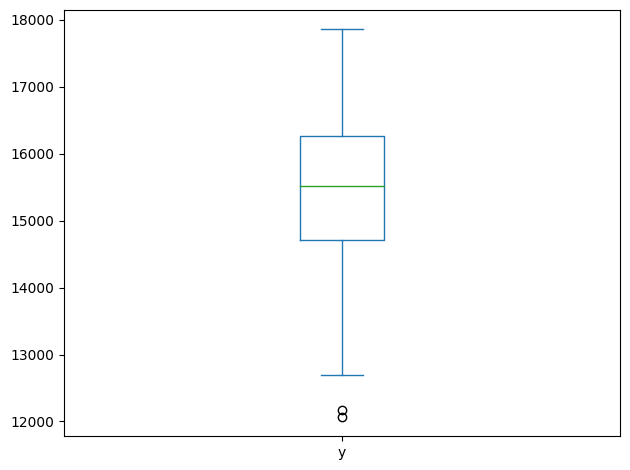

In [ ]:
train_df["y"].plot(kind = "box", subplots = True)
plt.tight_layout()
plt.show()

Time series plots

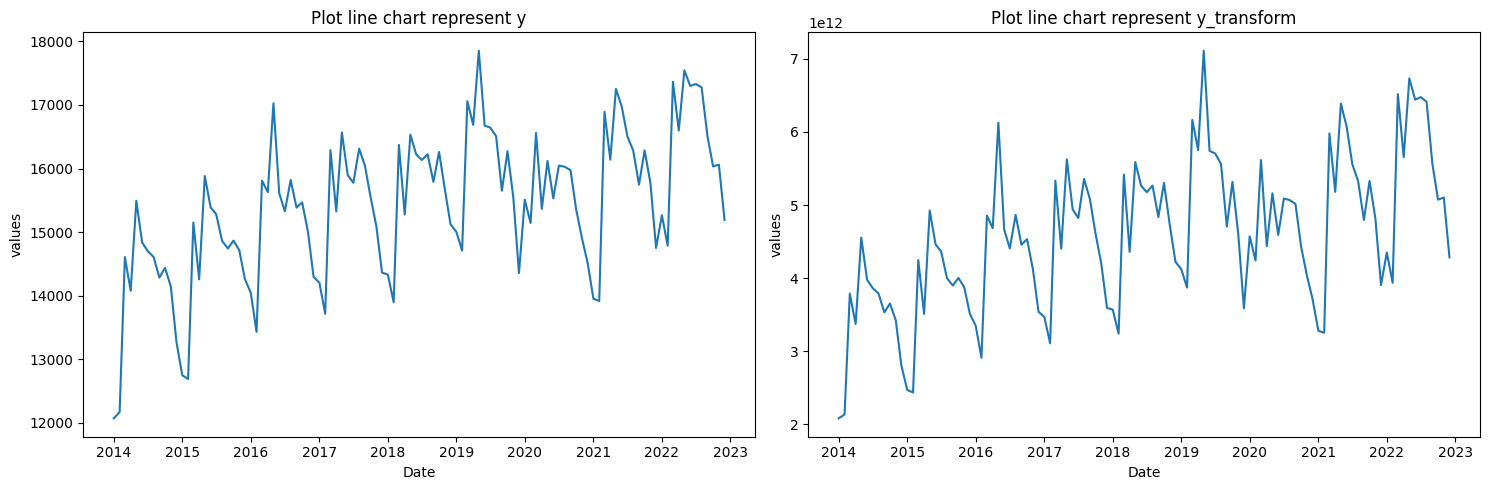

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5), facecolor = "w")
for i, col in enumerate(train_df.columns):
    ax[i].plot(train_df[col])
    ax[i].set(xlabel = "Date", ylabel = "values", title = f"Plot line chart represent {train_df[col].name}")
plt.tight_layout()
plt.show()

Seasonal check

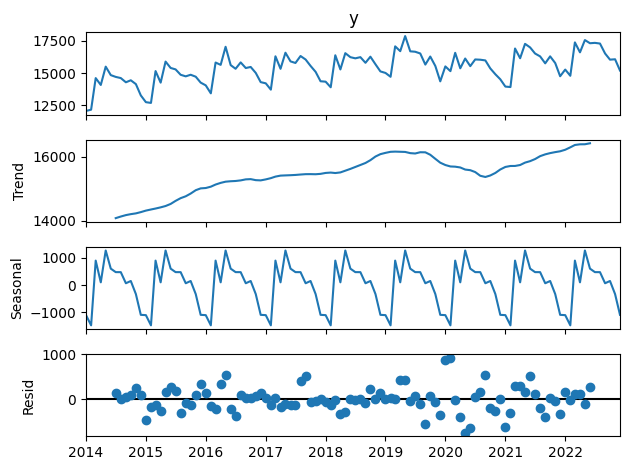

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decompose
sd = seasonal_decompose(train_df["y"], model = "additive", period = 12)

# Plot
sd.plot()
plt.tight_layout()
plt.show()

In [ ]:
sd.seasonal.values.reshape(int(len(train) / 12), 12)[0] * 100

array([-110675.55470159, -148113.70303245,   89561.85579841,
          9742.43409632,  126789.42230257,   60045.37633226,
         47278.85398433,   47184.47452444,    6434.14777601,
         14726.9392708 ,  -33399.24965264, -109574.99669847])

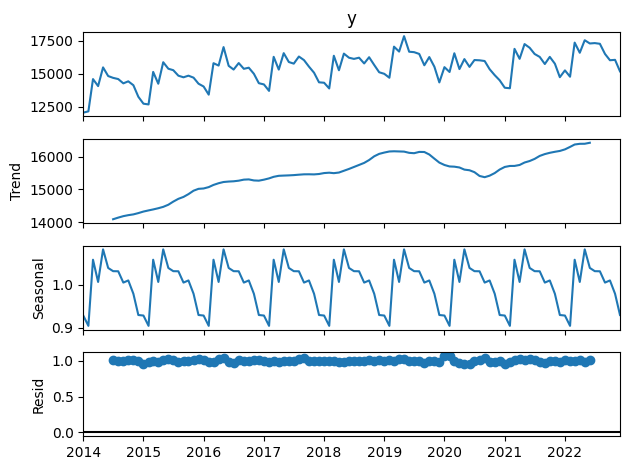

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decompose
sd = seasonal_decompose(train_df["y"], model = "multiplicative", period = 12)

# Plot
sd.plot()
plt.tight_layout()
plt.show()

In [ ]:
sd.seasonal.values.reshape(int(len(train) / 12), 12)[0] * 100 # Have seasonal impact (>= 5%)

array([ 92.81062786,  90.4221048 , 105.75601938, 100.60144762,
       108.16263409, 103.85087341, 103.10487031, 103.07999844,
       100.45819668, 100.95500447,  97.86135411,  92.93686883])

# Stationary checking

In [ ]:
# Definition ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

In [ ]:
adf_test(train_df["y"]) # P-value > 0.05, Non-stationary

Test Statistic                 -1.656897
p-value                         0.453446
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64

In [ ]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(train_df["y"]).keys()
df_adf['ADF seasonal differencing order 0'] = adf_test(train_df["y"]).values
df_adf['ADF seasonal differencing order 1'] = adf_test(train_df["y"].diff(periods = 12).dropna()).values
df_adf['ADF seasonal differencing order 2'] = adf_test(train_df["y"].diff(periods = 12).diff(periods = 12).dropna()).values
df_adf['ADF seasonal differencing order 3'] = adf_test(train_df["y"].diff(periods = 12).diff(periods = 12).diff(periods = 12).dropna()).values
df_adf['ADF seasonal differencing order 4'] = adf_test(train_df["y"].diff(periods = 12).diff(periods = 12).diff(periods = 12).diff(periods = 12).dropna()).values
round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)
# Diff until p-value < 0.05

,ADF seasonal differencing order 0,ADF seasonal differencing order 1,ADF seasonal differencing order 2,ADF seasonal differencing order 3,ADF seasonal differencing order 4
Test Statistic,-1.6569,-3.1145,-3.0880,-3.0387,-6.0978
p-value,0.4534,0.0255,0.0275,0.0314,0.0000
Critical Value (1%),-3.5011,-3.5117,-3.5260,-3.5464,-3.5746
Critical Value (5%),-2.8925,-2.8970,-2.9032,-2.9119,-2.9240
Critical Value (10%),-2.5833,-2.5857,-2.5890,-2.5937,-2.6000


# Seasonal Diferrencing

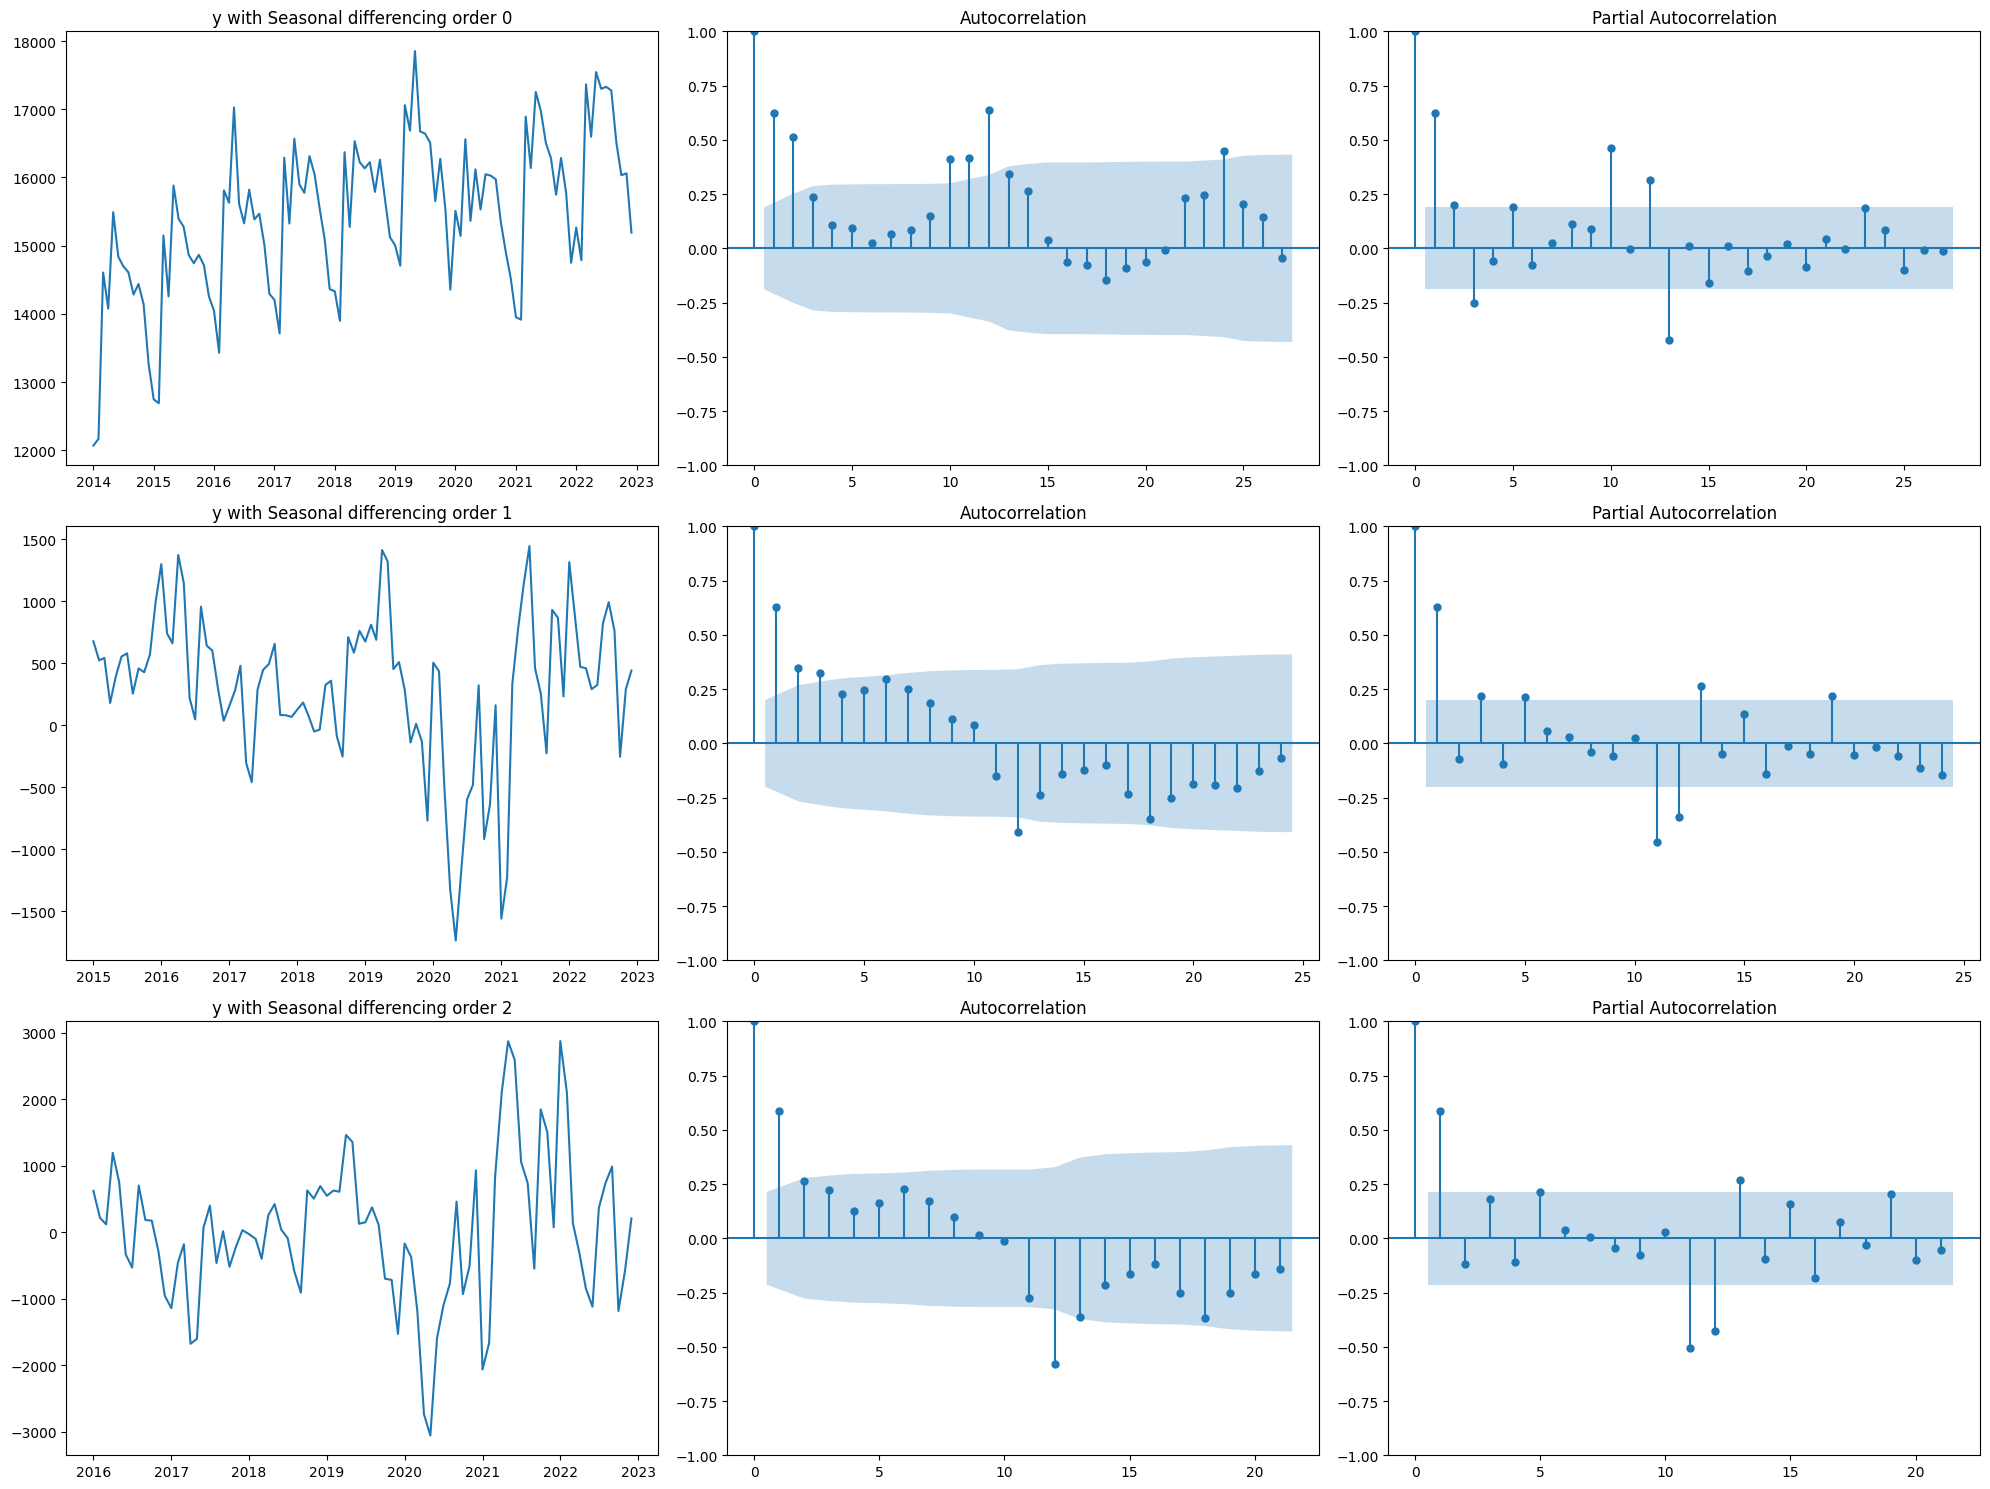

In [ ]:
fig, axes = plt.subplots(nrows =3, ncols = 3, figsize = (20, 15), facecolor = 'w')

# Seasonal differencing order 0
axes[0, 0].plot(train_df["y"].dropna())
axes[0, 0].set_title('y with Seasonal differencing order 0')
plot_acf(train_df["y"].dropna(), ax = axes[0, 1], lags = round(len(train_df["y"])/4))
plot_pacf(train_df["y"].dropna(), ax = axes[0, 2], lags = round(len(train_df["y"])/4))

# Seasonal differencing order 1
axes[1, 0].plot(train_df["y"].diff(periods = 12).dropna())
axes[1, 0].set_title('y with Seasonal differencing order 1')
plot_acf(train_df["y"].diff(periods = 12).dropna(), ax = axes[1, 1], lags = round(len(train_df["y"].diff(periods = 12).dropna())/4))
plot_pacf(train_df["y"].diff(periods = 12).dropna(), ax = axes[1, 2], lags = round(len(train_df["y"].diff(periods = 12).dropna())/4))

# Seasonal differencing order 2
axes[2, 0].plot(train_df["y"].diff(periods = 12).diff(periods = 12).dropna())
axes[2, 0].set_title('y with Seasonal differencing order 2')
plot_acf(train_df["y"].diff(periods = 12).diff(periods = 12).dropna(), ax = axes[2, 1], lags = round(len(train_df["y"].diff(periods = 12).diff(periods = 12).dropna())/4))
plot_pacf(train_df["y"].diff(periods = 12).diff(periods = 12).dropna(), ax = axes[2, 2], lags = round(len(train_df["y"].diff(periods = 12).diff(periods = 12).dropna())/4))
plt.tight_layout()
plt.show()

# SARIMA

In [ ]:
import itertools
max_p  = [0, 1];  max_d = [0];  max_q = [0, 1, 2, 3] # Possible p, d, q
max_SP = [0, 1, 2]; max_SD = [1, 2]; max_SQ = [0, 1] # Possible P, D, Q
periods = [12] # Month
order_combinations = list(itertools.product(max_p, max_d, max_q, max_SP, max_SD, max_SQ, periods)) # (p,d,q)(P, D, Q)s
len(order_combinations)
# 192 Orders

96

In [ ]:
list_arima_model = list()
for order in order_combinations:
    start_idx = order[1] + (order[4] * 12)
    model = ARIMA(endog = train_df["y"], order = order[:3], seasonal_order = order[3:]).fit()
    fitted = model.fittedvalues
    forecast = model.forecast(steps = len(test))
    mape_train = MAPE(train_df["y"][start_idx:], fitted[start_idx:]) * 100; mse_train = MSE(train_df["y"][start_idx:], fitted[start_idx:]); mae_train = MAE(train_df["y"][start_idx:], fitted[start_idx:])
    mape_test = MAPE(test, forecast) * 100; mse_test = MSE(test, forecast); mae_test = MAE(test, forecast)
    list_arima_model.append({"order": order[:3], "seasonal order": order[3:],
                             "MAPE train": mape_train, "RMSE train": sqrt(mse_train), "MAE train": mae_train,
                             "MAPE test": mape_test, "RMSE test": sqrt(mse_test), "MAE test": mae_test})
output_arima = round(pd.DataFrame(list_arima_model), 4)
output_arima = output_arima.sort_values(by = "MAPE train", ascending = True).reset_index(drop = True)
output_arima

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,order,seasonal order,MAPE train,RMSE train,MAE train,MAPE test,RMSE test,MAE test
0,"(1, 0, 2)","(1, 1, 1, 12)",2.0037,408.0747,308.5905,3.8437,698.9735,658.7140
1,"(1, 0, 3)","(1, 1, 1, 12)",2.0040,398.5657,310.1085,4.1779,773.2664,720.3472
2,"(1, 0, 3)","(0, 1, 1, 12)",2.0061,396.8231,309.8180,4.1175,756.9898,709.2985
3,"(1, 0, 2)","(0, 1, 1, 12)",2.0752,410.7077,319.3634,4.2426,786.9534,731.6270
4,"(1, 0, 2)","(2, 1, 1, 12)",2.1186,434.4021,328.4652,4.1430,786.9308,715.8019
...,...,...,...,...,...,...,...,...
91,"(0, 0, 0)","(1, 2, 1, 12)",5.0166,1038.4379,786.5966,3.5813,751.1713,593.7860
92,"(0, 0, 0)","(2, 2, 0, 12)",5.0214,1039.8573,787.4303,3.6027,754.7382,597.2522
93,"(0, 0, 0)","(0, 2, 1, 12)",5.0543,1040.8704,792.5194,3.6784,768.7291,609.9965
94,"(0, 0, 0)","(0, 2, 0, 12)",5.2067,1097.2207,820.6721,4.3921,892.8490,724.9516


## SARIMA from MAPE train



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  108
Model:             ARIMA(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -706.034
Date:                           Fri, 01 Mar 2024   AIC                           1422.068
Time:                                   15:51:13   BIC                           1434.889
Sample:                               01-01-2014   HQIC                          1427.250
                                    - 12-01-2022   Scale                       124987.753
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9747      0.023     43.190      0.000       0.930       1.019
ma.L1         -0.4022      0.079     -5.106

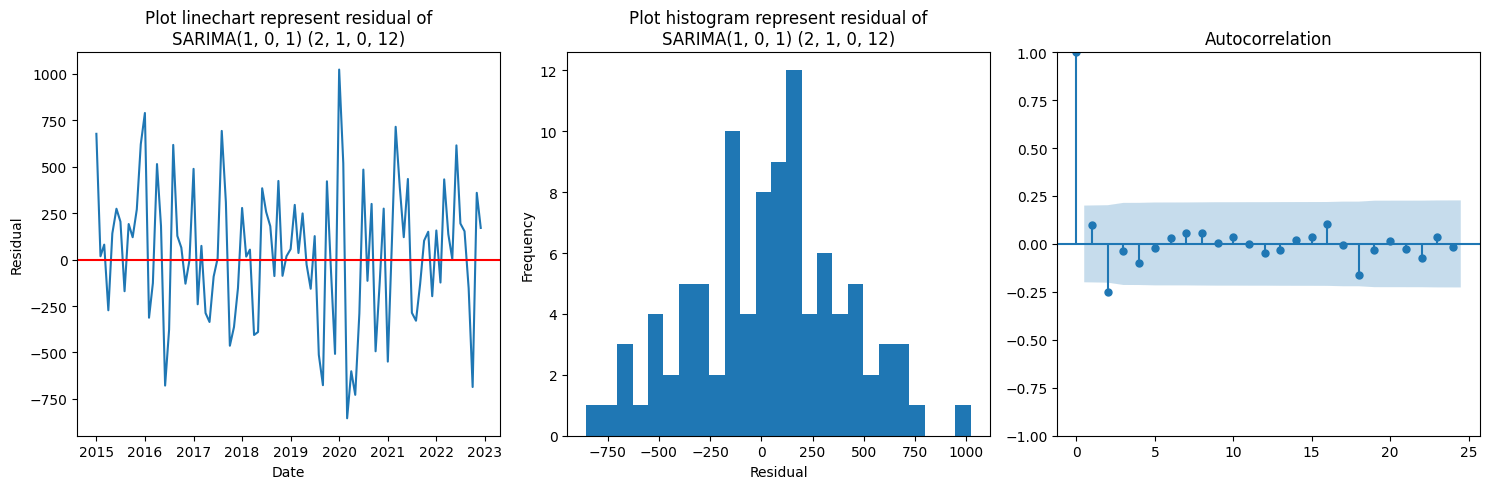

In [ ]:
id = 17
sarima_model = ARIMA(endog=train_df["y"], order=output_arima.iloc[id, 0], seasonal_order=output_arima.iloc[id, 1], concentrate_scale=True).fit()

print(sarima_model.summary())

# Error
print()
print("MAPE Train:", MAPE(train_df["y"][12:], sarima_model.fittedvalues[12:]) * 100)
print("MAPE Test:", MAPE(test, sarima_model.forecast(steps=len(test))) * 100)

# Diagnostic
resid_arima = sarima_model.resid[12:]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), facecolor="w")
ax[0].plot(resid_arima)
ax[0].axhline(y=0, color="r")
ax[0].set(xlabel="Date", ylabel="Residual", title="Plot linechart represent residual of\nSARIMA(1, 0, 1) (2, 1, 0, 12)")
ax[1].hist(resid_arima, bins=25)
ax[1].set(xlabel="Residual", ylabel="Frequency", title="Plot histogram represent residual of\nSARIMA(1, 0, 1) (2, 1, 0, 12)")
plot_acf(resid_arima, lags=int(len(resid_arima) / 4), ax=ax[2])

# Calculate R-squared
y_mean = train_df["y"].mean()
TSS = ((train_df["y"] - y_mean) ** 2).sum()
forecasted_values = sarima_model.fittedvalues[12:]  # Exclude first 12 values since differenced
RSS = (resid_arima ** 2).sum()
r_squared = 1 - (RSS / TSS)
print("Approximate R-squared:", r_squared)

plt.tight_layout()
plt.show()

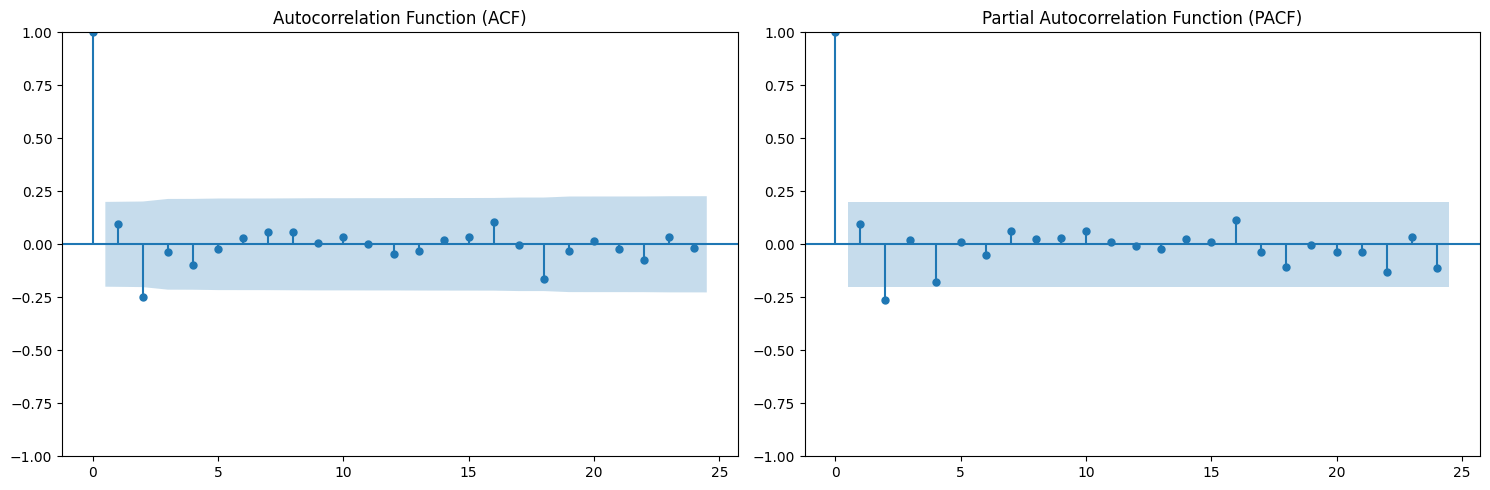

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), facecolor="w")

plot_acf(sarima_model.resid[12:], lags=int(len(sarima_model.resid[12:]) / 4), ax=ax1)
plot_pacf(sarima_model.resid[12:], lags=int(len(sarima_model.resid[12:]) / 4), ax=ax2)

ax1.set_title('Autocorrelation Function (ACF)')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
# Independence check
from statsmodels.stats.diagnostic import acorr_ljungbox
lag_idx = round(len(sarima_model.resid[12:])/4, 0)
bj = acorr_ljungbox(sarima_model.resid[12:], lags = lag_idx, return_df = True)
bj.tail().T

# Last lag have p-value > 0.05 = Can use this model

,20,21,22,23,24
lb_stat,14.555981,14.630212,15.336004,15.498500,15.530695
lb_pvalue,0.801226,0.841039,0.847419,0.875882,0.904266


# Auto SARIMA

In [ ]:
search_arima = auto_arima(train_df["y"], m = 12, information_criterion = "aic", stepwise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1772.905, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1691.897, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1730.193, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1771.013, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1761.945, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1651.363, Time=1.56 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1727.627, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1646.002, Time=1.94 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1652.127, Time=1.92 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1643.637, Time=1.47 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1647.972, Time=0.66 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept

In [ ]:
# Can i just REMOVE THE INTERCEPT?
print(search_arima.summary())
# If Auto SARIMA is the best model, but some parameter have p-value > 0.05 -> you can't use this model
# If intercept has p-value > 0.05, this model can still be used, but you should cut the intercept off

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood                -816.819
Date:                              Fri, 01 Mar 2024   AIC                           1643.637
Time:                                      10:02:03   BIC                           1657.002
Sample:                                  01-01-2014   HQIC                          1649.055
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.3011      3.986     -0.577      0.564     -10.114       5.512
ar.S.L12       0.69

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             ARIMA(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood                -800.779
Date:                            Fri, 01 Mar 2024   AIC                           1609.557
Time:                                    10:02:10   BIC                           1620.248
Sample:                                01-01-2014   HQIC                          1613.891
                                     - 12-01-2022   Scale                       130871.512
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7569      0.132      5.727      0.000       0.498       1.016
ar.S.L24       0.2396      0.129   

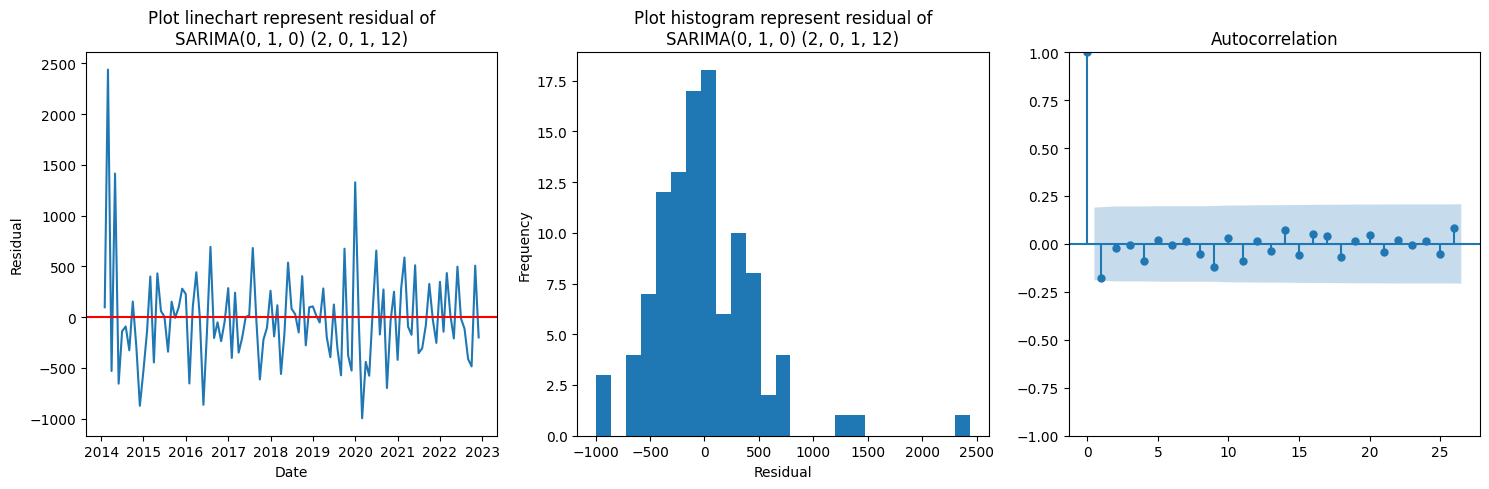

In [ ]:
sarima_grid = ARIMA(endog = train_df["y"], order = (0, 1, 0), seasonal_order = (2, 0, 1, 12), concentrate_scale = True).fit()
print(sarima_grid.summary())

# Error
print()
print("MAPE Train: ", MAPE(train_df["y"][1:], sarima_grid.fittedvalues[1:]) * 100)
print("MAPE Test: ", MAPE(test, sarima_grid.forecast(steps = len(test))) * 100)

# Diagnostic
resid_arima = sarima_grid.resid[1:]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
ax[0].plot(resid_arima)
ax[0].axhline(y = 0, color = "r")
ax[0].set(xlabel = "Date", ylabel = "Residual", title = "Plot linechart represent residual of\nSARIMA(0, 1, 0) (2, 0, 1, 12)")
ax[1].hist(resid_arima, bins = 25)
ax[1].set(xlabel = "Residual", ylabel = "Frequency",title = "Plot histogram represent residual of\nSARIMA(0, 1, 0) (2, 0, 1, 12)")
plot_acf(resid_arima, lags = int(len(resid_arima) / 4), ax = ax[2])
plt.tight_layout()
plt.show()

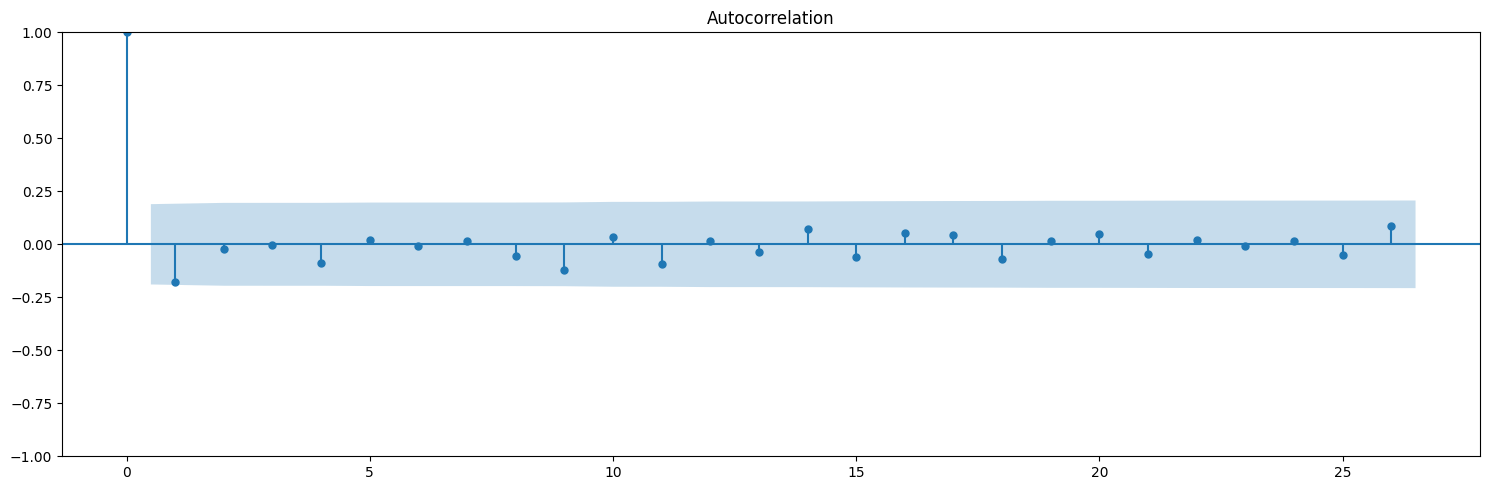

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), facecolor = "w")
plot_acf(sarima_grid.resid[1:], lags = int(len(sarima_grid.resid[1:]) / 4), ax = ax)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lag_idx = round(len(sarima_grid.resid[1:])/4, 0)
bj = acorr_ljungbox(sarima_grid.resid[1:], lags = lag_idx, return_df = True)
bj.tail().T

,23,24,25,26,27
lb_stat,10.916438,10.946995,11.302355,12.358371,13.941363
lb_pvalue,0.984025,0.989385,0.991344,0.988966,0.981821


# Forecast dataframe

In [ ]:
fitted = pd.DataFrame(
    {
        "y_train": train[12:],
        "SARIMA": sarima_model.fittedvalues[12:],
    }
)
fitted

,y_train,SARIMA
2015-01-01,12745.673474,12068.696492
2015-02-01,12689.018185,12671.203898
2015-03-01,15148.966499,15068.346793
2015-04-01,14255.842150,14528.701210
2015-05-01,15881.919642,15741.352520
...,...,...
2022-08-01,17275.767586,17123.250441
2022-09-01,16507.747286,16661.919307
2022-10-01,16032.220729,16718.027603
2022-11-01,16061.447395,15701.987378


In [ ]:
fitted.to_excel(r"fitted SARIMA.xlsx")

In [ ]:
error_fit = pd.DataFrame()
for i in fitted.columns[1:]:
    error_fit[i] = fitted["y_train"] - fitted[i]
error_fit

,SARIMA
2015-01-01,676.976982
2015-02-01,17.814287
2015-03-01,80.619706
2015-04-01,-272.859060
2015-05-01,140.567122
...,...
2022-08-01,152.517145
2022-09-01,-154.172021
2022-10-01,-685.806874
2022-11-01,359.460017


In [ ]:
error_fit.to_excel(r"Resid of SARIMA.xlsx")

In [ ]:
from sklearn.metrics import r2_score

diag_fitted = pd.DataFrame()
diag_fitted.index = fitted.columns[1:]
diag_fitted['MAPE'] = [MAPE(fitted['y_train'], fitted[i]) * 100 for i in fitted.columns[1:]]
diag_fitted['RMSE'] = [sqrt(MSE(fitted['y_train'], fitted[i])) for i in fitted.columns[1:]]
diag_fitted['MAE']  = [MAE(fitted['y_train'], fitted[i]) for i in fitted.columns[1:]]

MPE_values = []
for i in fitted.columns[1:]:
  errors = (fitted[i] - fitted['y_train']) / fitted['y_train'] * 100
  MPE_values.append(errors.mean())
diag_fitted['MPE'] = MPE_values

round(diag_fitted, 4)

# SARIMA Grid is the bestest model, selected by AIC
# LOWEST MAPE, ALL PARAMETER IN MODEL, PASS RESIDUAL ANALYSIS = THE BEST MODEL

,MAPE,RMSE,MAE,MPE
SARIMA,1.9236,373.5423,298.6159,-0.2299


In [ ]:
fitted = pd.DataFrame(
    {
        "y_train": train[1:],
        "SARIMA Grid": sarima_grid.fittedvalues[1:]
    }
)
fitted

,y_train,SARIMA Grid
2014-02-01,12166.241841,12068.437526
2014-03-01,14606.003261,12166.241841
2014-04-01,14075.957495,14606.003261
2014-05-01,15491.379398,14075.957495
2014-06-01,14836.816693,15491.379398
...,...,...
2022-08-01,17275.767586,17389.008850
2022-09-01,16507.747286,16920.129084
2022-10-01,16032.220729,16516.372039
2022-11-01,16061.447395,15553.909810


In [ ]:
fitted.to_excel(r"fitted SARIMA-GRID.xlsx")

In [ ]:
error_fit = pd.DataFrame()
for i in fitted.columns[1:]:
    error_fit[i] = fitted["y_train"] - fitted[i]
error_fit

,SARIMA Grid
2014-02-01,97.804315
2014-03-01,2439.761420
2014-04-01,-530.045766
2014-05-01,1415.421903
2014-06-01,-654.562705
...,...
2022-08-01,-113.241264
2022-09-01,-412.381798
2022-10-01,-484.151310
2022-11-01,507.537585


In [ ]:
error_fit.to_excel(r"Resid of SARIMA-GRID.xlsx")

In [ ]:
from sklearn.metrics import r2_score

diag_fitted = pd.DataFrame()
diag_fitted.index = fitted.columns[1:]
diag_fitted['MAPE'] = [MAPE(fitted['y_train'], fitted[i]) * 100 for i in fitted.columns[1:]]
diag_fitted['RMSE'] = [sqrt(MSE(fitted['y_train'], fitted[i])) for i in fitted.columns[1:]]
diag_fitted['MAE']  = [MAE(fitted['y_train'], fitted[i]) for i in fitted.columns[1:]]

MPE_values = []
for i in fitted.columns[1:]:
  errors = (fitted[i] - fitted['y_train']) / fitted['y_train'] * 100
  MPE_values.append(errors.mean())
diag_fitted['MPE'] = MPE_values

round(diag_fitted, 4)

# SARIMA Grid is the bestest model, selected by AIC
# LOWEST MAPE, ALL PARAMETER IN MODEL, PASS RESIDUAL ANALYSIS = THE BEST MODEL

,MAPE,RMSE,MAE,MPE
SARIMA Grid,2.1697,471.6355,332.5034,0.1189


In [ ]:
fitted = pd.DataFrame(
    {
        "y_train": train[12:],
        "SARIMA": sarima_model.fittedvalues[12:],
        "SARIMA Grid": sarima_grid.fittedvalues[12:]
    }
)
fitted

AttributeError: 'SARIMAX' object has no attribute 'forecast'

In [ ]:
# Plot comparing model
import plotly.graph_objects as go

fig = go.Figure()
for i in list(fitted.columns):
    fig.add_trace(go.Scatter(x = fitted.index, y = fitted[i], name = i, line_shape='linear'))

fig.update_layout(title = "Line chart for comparing train model",
                  xaxis_title = "Date",
                  yaxis_title = "Electricity consumption (GWh)",
                  legend_title = "Model")
fig.show()

# SARIMA GRID = Best model from AIC

# Forecast through 2024

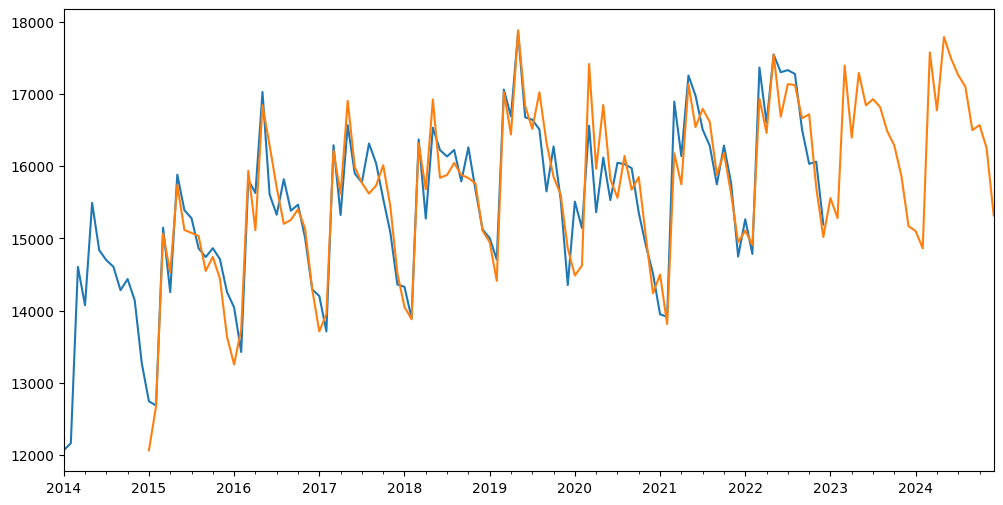

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA WITH DATA

sarima = SARIMAX(endog = train_df["y"], order=(1, 0, 1), seasonal_order=(2, 1, 0, 12), concentrate_scale = True)

sarima_fit = sarima.fit(optimized=True)
yhat_sarima = sarima_fit.predict('2015-01-01', '2024-12-01')

plt.figure(figsize=(12,6))
train.plot()
yhat_sarima.plot();

In [ ]:
yhat_sarima

2015-01-01    12068.696492
2015-02-01    12671.203898
2015-03-01    15068.346793
2015-04-01    14528.701210
2015-05-01    15741.352520
                  ...     
2024-08-01    17101.480433
2024-09-01    16498.800359
2024-10-01    16568.313144
2024-11-01    16249.729617
2024-12-01    15317.233244
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

In [ ]:
yhat_sarima.to_excel(r"Predict SARIMA.xlsx")

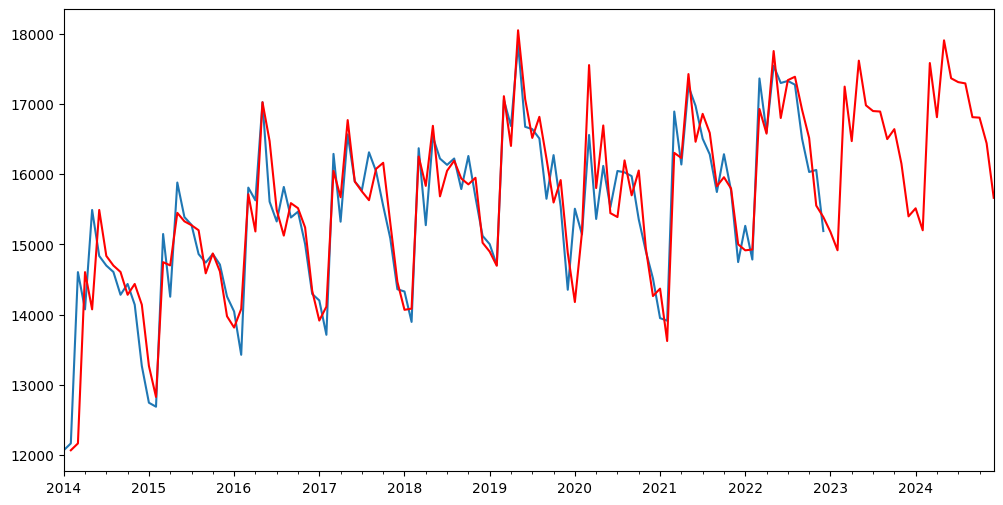

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA GRID WITH DATA

sarima_grid = SARIMAX(endog = train_df["y"], order=(0, 1, 0), seasonal_order=(2, 0, 1, 12), concentrate_scale = True)

sarima_fit = sarima_grid.fit(optimized=True)
yhat_sarima_grid = sarima_fit.predict('2014-02-01', '2024-12-01')

plt.figure(figsize=(12,6))
train.plot()
yhat_sarima_grid.plot(color='Red');

In [ ]:
yhat_sarima_grid

2014-02-01    12068.437526
2014-03-01    12166.241841
2014-04-01    14606.003261
2014-05-01    14075.957495
2014-06-01    15491.379398
                  ...     
2024-08-01    17294.377859
2024-09-01    16813.245502
2024-10-01    16806.469585
2024-11-01    16440.988457
2024-12-01    15664.688170
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64

## Forecast testset

In [ ]:
forecast = pd.DataFrame(
    {
        "y_test":       test,
        "SARIMA":       sarima_model.forecast(steps=len(test)),
        "SARIMA Grid":  sarima_grid.forecast(steps=len(test))
    }
)
forecast

,y_test,SARIMA,SARIMA Grid
2023-01-01,14679.442038,15559.084020,15179.274936
2023-02-01,14757.677469,15280.186443,14917.317245
2023-03-01,17023.344297,17392.154068,17248.496803
2023-04-01,17826.101698,16394.843847,16472.317212
2023-05-01,18975.456090,17289.202732,17618.152059
2023-06-01,17780.568173,16841.494093,16981.811288
2023-07-01,17902.338324,16927.534867,16900.378399
2023-08-01,17862.799969,16816.423543,16893.473562
2023-09-01,17124.685377,16483.197429,16500.969845
2023-10-01,17180.417395,16285.463262,16642.557371


In [ ]:
forecast.to_excel(r"forecast test.xlsx")

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
for i in list(forecast.columns):
    fig.add_trace(go.Scatter(x = forecast.index, y = forecast[i], name = i, line_shape='linear'))

fig.update_layout(title = "Line chart for compare test model",
                  xaxis_title = "Date",
                  yaxis_title = "Electricity Consumption (GWh) ",
                  legend_title = "Model")
fig.show()

In [ ]:
from sklearn.metrics import r2_score

diag_forecast = pd.DataFrame()
diag_forecast.index = forecast.columns[1:]
diag_forecast['MAPE'] = [MAPE(forecast['y_test'], forecast[i]) * 100 for i in forecast.columns[1:]]
diag_forecast['RMSE'] = [sqrt(MSE(forecast['y_test'], forecast[i])) for i in forecast.columns[1:]]
diag_forecast['MAE']  = [MAE(forecast['y_test'], forecast[i]) for i in forecast.columns[1:]]

MPE_values = []
for i in forecast.columns[1:]:
  errors = (forecast[i] - forecast['y_test']) / forecast['y_test'] * 100
  MPE_values.append(errors.mean())
diag_forecast['MPE'] = MPE_values

round(diag_forecast, 4)

,MAPE,RMSE,MAE,MPE
0,NaN,NaN,NaN,-3.4689
1,NaN,NaN,NaN,-3.2439
